# Python vs Matlab calibration comparison

## Objective: compare calibration checkerboard detection in python (opencv) & matlab (toolbox)

### Test 1: single image, intrinsic camera calibration

In [1]:
# all imports
import numpy as np
import cv2
from PIL import Image
from cv2 import aruco
import glob
import time
import pandas as pd
import pickle
import math
import cairo

from scipy.io import loadmat, savemat
from src.calibration.new.video_utils import get_chessboard_coordinates, imshow, imshow_cv2, load_images, get_first_frame_video
from src.calibration.new.project_utils import get_calibration_paths, get_extrinsics_dir, get_intrinsics_dir, get_camera_names, get_extrinsics_video_paths, get_intrinsics_image_paths, write_calibration_params
from src.calibration.new.intrinsics import IntrinsicsParams
from src.calibration.new.extrinsics import ExtrinsicsParams
from dataclasses import dataclass, field

# extra imports
import os
import matplotlib.pyplot as plt


In [2]:
### ASSUME CAMERA IDX 0 ("Camera1")

# load test calibrations
param_path_cv2 = "/Users/caxon/olveczky/dannce_data/setupCal11_010324/out_cv2/hires_cam1_params.mat"
vid_path = "/Users/caxon/olveczky/dannce_data/setupCal11_010324/extrinsic/Camera1/0.mp4"
with open('intrinsics.pkl', 'rb') as handle:
    intrinsics_container = pickle.load(handle)

test_img = get_first_frame_video(vid_path)

if intrinsics_container['camera_idx'] != 0:
    raise Exception("Wrong camera index")

if len(intrinsics_container['failed_imgs']) >= 1:
    raise Exception("Failed images are present - not supported")
    
intrinsics_cv2 = intrinsics_container['intrinsics']
r_vecs = intrinsics_container['r_vecs']
t_vecs = intrinsics_container['t_vecs']
objpoints = intrinsics_container['objpoints']
imgpoints = intrinsics_container['imgpoints']
failed_imgs = intrinsics_container['failed_imgs']
reproject_err_total = intrinsics_container['reproject_err'] # px?
raw_images = intrinsics_container['raw_images']

print(reproject_err_total)

0.32228584179305153


In [172]:
this_img = raw_images[0, :, :, :].copy()
cv2.drawChessboardCorners(this_img, (6,9), imgpoints[0], False)
cv2.drawChessboardCorners(this_img, (6,9), re_imagepoints[0], True)

im2 = cv2.cvtColor(this_img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(im2)
im_pil.show()

In [171]:
# DRAW IMG POINTS & RE_IMG POINTS USING SUBPIXEL (cairo)

this_img = raw_images[0, :, :, :].copy()
px = imgpoints[0][0][0][0]
py = imgpoints[0][0][0][1]

cairo_img = np.ndarray(shape=(1200, 1920), dtype=np.uint32)
this_img_32 = this_img.astype(np.uint32)
cairo_img[:,:] = this_img_32[:,:,2] + (this_img_32[:,:,1] << 8) + (this_img_32[:,:,0] << 16) + (0xff << 24)

surface = cairo.ImageSurface.create_for_data( cairo_img, cairo.FORMAT_ARGB32, this_img.shape[1], this_img.shape[0])
ctx = cairo.Context(surface)

ipts = imgpoints[0].squeeze()

for ipt in ipts:
    px,py = ipt
    
    ctx.arc(px, py, 4, 0, 2*math.pi)
    ctx.set_source_rgb(1.0, 0, 1.0)
    ctx.set_line_width(1.0)
    ctx.stroke()
    
    ctx.arc(px, py, 0.25, 0, 2*math.pi)
    ctx.set_source_rgb(1.0, 0, 1.0)
    ctx.set_line_width(0.5)
    ctx.stroke()
    
re_ipts = re_imgpoints[0].squeeze()

for re_ipt in re_ipts:
    px,py = re_ipt
    
    ctx.arc(px, py, 4, 0, 2*math.pi)
    ctx.set_source_rgb(0, 1.0, 0)
    ctx.set_line_width(1.0)
    ctx.stroke()
    
    ctx.arc(px, py, 0.25, 0, 2*math.pi)
    ctx.set_source_rgb(0, 1.0, 0)
    ctx.set_line_width(0.5)
    ctx.stroke()

new_img_argb = np.ndarray(shape=(1200, 1920), dtype=np.uint32, buffer=surface.get_data())
new_img = np.ndarray(shape=(1200, 1920, 3), dtype=np.uint8)
new_img[:,:,0] = new_img_argb[:,:] & 0xff
new_img[:,:,1] = (new_img_argb[:,:] >> 8 ) & 0xff
new_img[:,:,2] = (new_img_argb[:,:] >> 16 ) & 0xff

pil_img = Image.fromarray(new_img)
pil_img.show()


In [5]:
def calculate_rpe(ipts, re_ipts):
    norms = np.linalg.norm(ipts - re_ipts, axis=1)
    avg = np.mean(norms, axis=0)
    return avg

n_images = len(raw_images)

rpes = []

for i in range( n_images ):
    ipts = imgpoints[i].squeeze()
    re_ipts = cv2.projectPoints(objpoints[i], r_vecs[i], t_vecs[i], intrinsics_cv2.camera_matrix, intrinsics_cv2.dist)
    re_ipts = re_ipts[0].squeeze()
    rpe = calculate_rpe(ipts, re_ipts)
    rpes.append(rpe)
    

In [122]:
sample_matlab_intrinsics = IntrinsicsParamsMatlab(focal_length=(2330.7, 2334.0), principal_point=(968.4690, 602.1258), image_size=(1200, 1920), radial_distortion=(-0.0718, 0.1175))

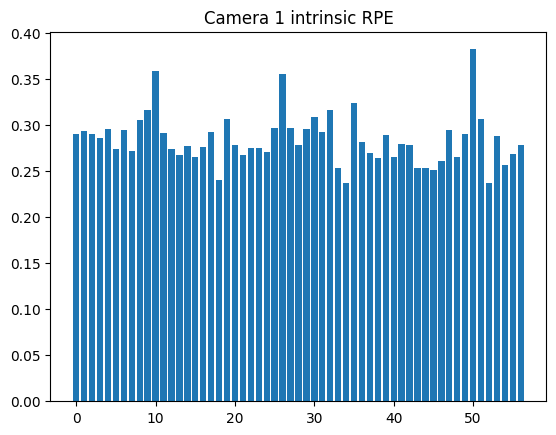

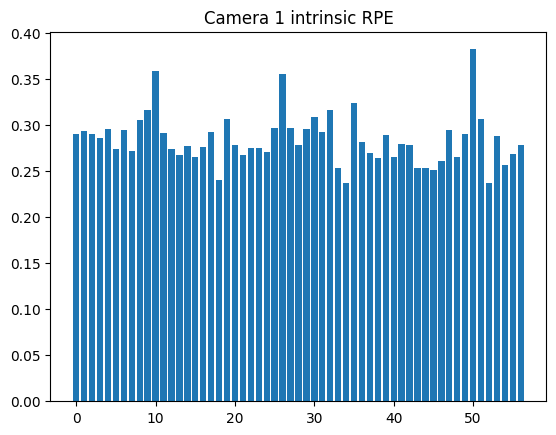

In [17]:
bar.set_label("TEST")

In [27]:
# load from matlab to compare

def get_hires_path(camera_idx):
    return f"/Users/caxon/olveczky/dannce_data/setupCal11_010324/calibration-old2/hires_cam{camera_idx+1}_params.mat"

cam0_param_path = get_hires_path(0)
print(f"PATH IS {path}")

def load_hires_mat(filepath):
    mat = loadmat(filepath)
    print(mat)


load_hires_mat(cam0_param_path)

PATH IS /Users/caxon/olveczky/dannce_data/setupCal11_010324/calibration-old2/hires_cam1_params.mat
{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Feb 25 22:20:58 2024', '__version__': '1.0', '__globals__': [], 'K': array([[2.32446619e+03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.32791287e+03, 0.00000000e+00],
       [9.69888498e+02, 5.95493637e+02, 1.00000000e+00]]), 'RDistort': array([[-0.07742088,  0.12972133]]), 'TDistort': array([[-0.00032314,  0.00026714]]), 'r': array([[ 0.98730464, -0.15808785,  0.01541974],
       [ 0.08046489,  0.41409069, -0.9066721 ],
       [ 0.13694868,  0.89640233,  0.42155418]]), 't': array([[ -40.48159345,   55.45614601, 1121.70050399]])}


In [67]:
mat = loadmat(cam0_param_path)

k = mat['K']

In [51]:
np.triu(k)
np.matmul(np.tril(k), np.triu(k))

k * np.identity(3)

array([[2.32446619e+03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.32791287e+03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [57]:
np.tril(k, k=-1)

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [969.88849812, 595.49363732,   0.        ]])

In [58]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [60]:
np.tril(x, k=-1)

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0]])

In [68]:
k[0,0]=123


In [69]:
k

array([[1.23000000e+02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.32791287e+03, 0.00000000e+00],
       [9.69888498e+02, 5.95493637e+02, 1.00000000e+00]])